In [1]:
from __future__ import division
import numpy as np
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
pool_size = multiprocessing.cpu_count()

# Data Exploration

Data source: https://archive.ics.uci.edu/dataset/228/sms+spam+collection

In [2]:
# Function to read the data

def read_data(filename):
    """
    Read SMS Spam data from data file into a dataframe.

    :param filename: Path to the dataset file.

    :return data_df: Pandas dataframe with "label" and "message" columns.
    """
    with open(filename, "r") as f:
        lines = f.read().splitlines()
    
    i = 0
    data = []
    while i < len(lines):
        parts = lines[i].strip().split('\t', 1) # Split only on the first tab
        data.append(parts)
        i+=1
    
    data_df = pd.DataFrame(data, columns=["label", "message"])
    return data_df

In [3]:
filename = ("Data/sms+spam+collection/SMSSpamCollection") # Path to the data file.

data = read_data(filename)

In [4]:
data.info() # Information about dataframe
data.head() # First 5 rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5574 non-null   object
 1   message  5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data.describe() # Statistics that describe the dataframe

,label,message
count,5574,5574
unique,2,5160
top,ham,"Sorry, I'll call later"
freq,4827,30


In [6]:
data.value_counts("label") # Counts unique rows 

label
ham     4827
spam     747
Name: count, dtype: int64

In [7]:
data.duplicated().sum() # How many duplicated rows are in the dataframe

414

In [8]:
data = data.drop_duplicates(keep = "first") # Remove duplicates
data = data.reset_index(drop=True) # Reset index 

In [9]:
data.duplicated().sum() # How many deduplicated rows are in dataframe
data.value_counts("label") # Counts unique rows

label
ham     4518
spam     642
Name: count, dtype: int64

Not Spam: 87.56 %
Spam: 12.44 %


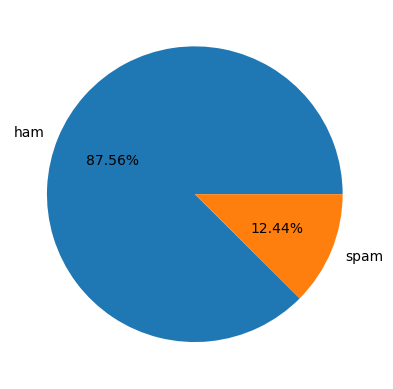

In [10]:
counts = data.value_counts("label")
print(f"Not Spam: {round(counts["ham"] / len(data) * 100, 2)} %")
print(f"Spam: {round(counts["spam"]/ len(data) * 100 , 2)} %")
plt.pie(data["label"].value_counts(),labels = ["ham", "spam"], autopct = "%.2f%%")
plt.show()

# Data Preprocessing

In [ ]:
import re
import string
import unicodedata
import html
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = set(ENGLISH_STOP_WORDS)
from nltk.stem import WordNetLemmatizer

def preprocess_message(message):
    """
    Preprocess messages, replacing various patterns with tokens, and lemmatizing them.

    :param message: SMS instance.

    :return: cleaned and lemmatized message.
    """
    
    message = html.unescape(message) # Decode HTML entities like "&lt;" into "<" and "&gt;" into ">"
    message = re.sub(r'<[^>]+>', ' ', message)  # Remove "<>"" tags

    message = re.sub(r'\s+', ' ', message).strip() # Remove extra spaces

    message = message.lower() # Convert to lowercase


    # Find data patterns
    date_patterns = [
        r'\b\d{1,2}(st|nd|rd|th)?\s+(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]*\s+\d{4}\b', # Matches formats like "21st May 2005"
        r'\b(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]*\s+\d{1,2}(st|nd|rd|th)?,?\s+\d{4}\b', # Matches formats like "May 21st, 2005"
        r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', # Matches formats like "21/05/2005"
        r'\b\d{4}[/-]\d{1,2}[/-]\d{1,2}\b' # Matches ISO/reversed formats like "2005-05-21"
    ]
    # Replace dates with <date> token
    for dp in date_patterns:
        message = re.sub(dp, '<date>', message)

    
    # Find time patterns
    time_patterns = [
        r'\b([01]?\d|2[0-3]):[0-5]\d\b', # Matches 24-hour format (e.g. 17:30)       
        r'\b(1[0-2]|0?[1-9]):[0-5][0-9]\s?(am|pm)\b',  # Matches 12-hour format (e.g.5:30 pm)
        r'\b(1[0-2]|0?[1-9])\s?(am|pm)\b'       # Matches hour with only am/pm (e.g. 5 am)
    ]
    # Replace times with <time> token
    for tp in time_patterns:
        message = re.sub(tp,'<time>', message)


    email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b') # Find email formats, e.g. abc@hotmail.com
    message = re.sub(email_pattern,'<email>', message) # Replace emails with <email> token
    
   
    message = re.sub(r'http\S+|www\S+','<url>', message) # Replace urls with <url> token
    
    emoticon_re = re.compile(r'(?:(?:[:;=8Xx][-^]?[)DdpP(/\|\\])|[)(][-^]?[:;=8Xx])') # Find emoticon pattern, e.g ":)"
    message = re.sub(emoticon_re,'<emoticon>', message) # Replace emoticons with <emoticon> token
    
    # Replace punctuation
    punctuation_to_keep = "!$£<>" # Keep "!";  "£" and "$" for money, and "<>" for the tokens
    punctuation_to_remove = "".join(ch for ch in string.punctuation if ch not in punctuation_to_keep) # Remove any other punctuation
    message  = message.translate(str.maketrans("", "", punctuation_to_remove)) # Remove any other punctuation from message
    
    # Phone numbe pattern
    phone_pattern = re.compile(
        r'\b\d{7,15}\b|(?:(?:\+?\d{1,3}[\s.-]?)?(?:\(?\d{2,4}\)?[\s.-]?){1,3}\d{2,4})'
    )
    message = re.sub(phone_pattern, '<phone>', message) # Replace phone numbers with <phone> token

    message = re.sub(r'[\$£]+', '<money>', message) # Replace money with "<money>" token
    
    message = re.sub(r'\d+', '<num>', message) # Replace other numbers with "<num>" token

    message = unicodedata.normalize('NFKD', message).encode('ascii', 'ignore').decode('ascii') # Normalize unicode to ASCII (e.g ü to u)
    
    tokens = message.split() # Split the message into tokens
    tokens = [t for t in tokens if t not in stop_words]  # Remove English stop words (e.g. "the", "and")

    lemmatizer = WordNetLemmatizer() # Initialize lemmatizer
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens] # Reduce every word to its lemma (dictionary/ base form)

    return ' '.join(lemmatized_words)


In [12]:
# Add preprocessed messages to dataframe

data["preprocessed message"] = data["message"].apply(preprocess_message)

In [13]:
# Get the most common words in spam messages

from collections import Counter
spam_words = Counter(" ".join(data[data["label"]=="spam"]["preprocessed message"]).split())
most_common = [w for w, c in spam_words.most_common(100)]
most_common

['<phone>',
 '<num>',
 'free',
 '<money><num>',
 'txt',
 'text',
 'ur',
 'u',
 'stop',
 'mobile',
 'claim',
 'reply',
 '<money><phone>',
 '<url>',
 'prize',
 'just',
 'new',
 'service',
 'send',
 'tone',
 '<num>p',
 'won',
 'now!',
 'nokia',
 'cash',
 'contact',
 'phone',
 'win',
 'min',
 'tc',
 'week',
 'urgent!',
 'customer',
 'guaranteed',
 'message',
 'number',
 'chat',
 'line',
 'msg',
 'draw',
 'awarded',
 '<num>ppm',
 'latest',
 'want',
 'video',
 'show',
 'landline',
 'box',
 'voucher',
 'receive',
 'code',
 'c',
 'today',
 'offer',
 'network',
 'po',
 'holiday',
 'rate',
 'apply',
 'orange',
 'cost',
 'ringtone',
 'sm',
 'you!',
 'entry',
 'selected',
 'live',
 'attempt',
 'collection',
 'valid',
 'chance',
 'day',
 'word',
 'camera',
 'pound',
 'uk',
 'award',
 'collect',
 '<num>st',
 '<num>nd',
 '<date>',
 'r',
 'delivery',
 'mob',
 '<num>hrs',
 'account',
 'game',
 'weekly',
 '<num>pmin',
 'time',
 'end',
 'sae',
 'tried',
 'bonus',
 'urgent',
 'e<emoticon>ires',
 'know',
 

# Training, test and validation data

In [14]:
def encode_message(message, features):
    """
    Encode a message into a binary array based on a list of features. Indicate the presence or absence of a feature.

    :param message: preprocessed message.
    :param features: list of words (features) to encode.

    :return: array of length features indicating wether each feature is present.
    """
    words = set(message.split())
    return np.array([1 if f in words else 0 for f in features])

In [15]:
from sklearn.model_selection import train_test_split

# Separate ham and spam
ham_data = data[data['label'] == 'ham']
spam_data = data[data['label'] == 'spam']

# Split ham data into 80% training, 10% validation, 10% testing
ham_train, ham_val_test = train_test_split(ham_data, test_size=0.2, random_state=42, shuffle=True) # Split ham into training (80%) and validation/test (20%)
ham_val, ham_test = train_test_split(ham_val_test, test_size=0.5, random_state=42, shuffle=True) # Split ham_val_test into validation (10%) and testing (10%)

# Split spam data into 50% validation and 50% testing
spam_val, spam_test = train_test_split(spam_data, test_size=0.5, random_state=42, shuffle=True)

Train instances:  3614


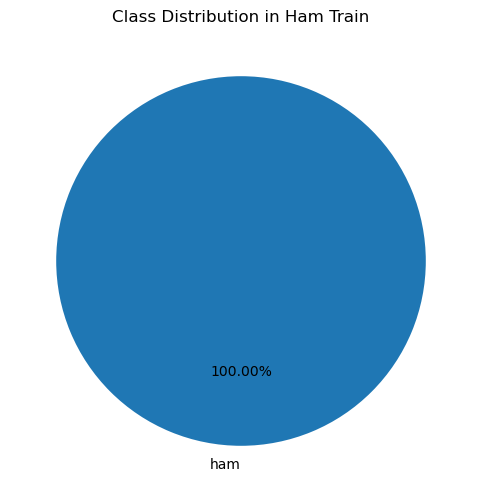

In [16]:
print("Train instances: ", len(ham_train))

counts_train = ham_train['label'].value_counts() 
plt.figure(figsize=(6,6))
plt.pie(counts_train.values, labels=counts_train.index, autopct='%.2f%%', startangle=90) # will be 100%
plt.title("Class Distribution in Ham Train")
plt.show()

In [17]:
X_train = np.array([encode_message(m, most_common) for m in ham_train["preprocessed message"]]) # Encode training data

# Encode validation data (both spam and ham)
encode_ham_val = np.array([encode_message(m, most_common) for m in ham_val["preprocessed message"]]) # Encode ham validation
encode_spam_val = np.array([encode_message(m, most_common) for m in spam_val["preprocessed message"]]) # Encode spam validation
X_val = np.vstack([encode_ham_val, encode_spam_val]) # Add both to X_val
y_val = ["ham"]*len(encode_ham_val) + ["spam"]*len(encode_spam_val) # Validation true predictions

# Encode validation data (both spam and ham)
encode_ham_test = np.array([encode_message(m, most_common) for m in ham_test["preprocessed message"]]) # Encode ham test
encode_spam_test = np.array([encode_message(m, most_common) for m in spam_test["preprocessed message"]]) # Encode spam test
X_test = np.vstack([encode_ham_test, encode_spam_test]) # Add both to X_test
y_test = ["ham"]*len(encode_ham_test) + ["spam"]*len(encode_spam_test) # Test data; true predictions

Validation instances: 773
Not Spam Validation Instances 452
Spam Validation Instances:  321
Not Spam: 58.47 %
Spam: 41.53 %


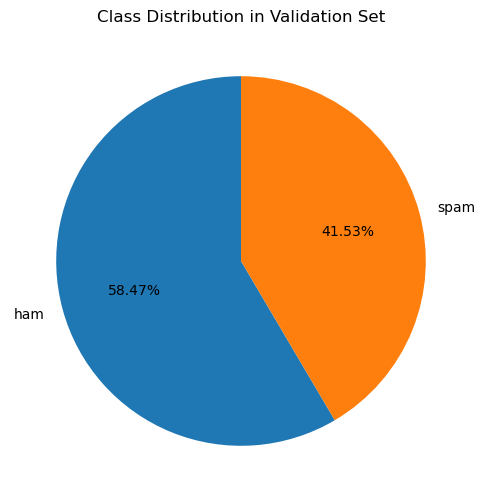

In [18]:
val_data = pd.concat([ham_val, spam_val])
print("Validation instances:", len(val_data))
print("Not Spam Validation Instances", len(ham_val))
print("Spam Validation Instances: ", len(spam_val))


counts_val = val_data['label'].value_counts()
print(f"Not Spam: {round(counts_val["ham"] / len(val_data) * 100, 2)} %")
print(f"Spam: {round(counts_val["spam"]/ len(val_data) * 100 , 2)} %")
plt.figure(figsize=(6,6))
plt.pie(counts_val.values, labels=counts_val.index, autopct='%.2f%%', startangle=90)
plt.title("Class Distribution in Validation Set")
plt.show()

Test Data Instances:  773
Test Not Spam Instances: 452
Test Spam Instances:  321
Not Spam: 58.47 %
Spam: 41.53 %


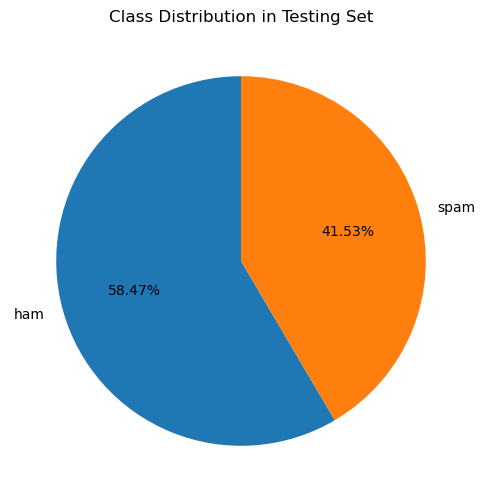

In [19]:
test_data = pd.concat([ham_test, spam_test])
print("Test Data Instances: ", len(test_data))
print("Test Not Spam Instances:", len(ham_test))
print("Test Spam Instances: ", len(spam_test))



counts_test = test_data['label'].value_counts()
print(f"Not Spam: {round(counts_test["ham"] / len(val_data) * 100, 2)} %")
print(f"Spam: {round(counts_test["spam"]/ len(val_data) * 100 , 2)} %")
plt.figure(figsize=(6,6))
plt.pie(counts_test.values, labels=counts_val.index, autopct='%.2f%%', startangle=90)
plt.title("Class Distribution in Testing Set")
plt.show()

# NSA Algorithm

In [20]:
def build_detectors(self_vectors, num_detectors, r, max_attempts, rng):
    """
    Builds detectors for the Negative Selection Algorithm, using Hamming distance.

    :param self_vectors: Array representing the self (ham messages).
    :param num_detectors: Number of detectors to generate.
    :param r: Hamming distance threshold. Distance must be higher than r for a detector.
    :param max_attempts: Maximum number of attempts to generate detectors.

    :return: Numpy array of detectors.
    """
    if rng is None:
        rng = np.random

    detectors = [] # Initialize detectors with empty list
    vocab_size = self_vectors.shape[1] # Size of feature vector 
    attempts = 0 # Initialize number of attempts with zero

    while len(detectors) < num_detectors and attempts < max_attempts:
        candidate = rng.randint(0, 2, vocab_size) # Randomly generated candidate vector 
        
        diff = self_vectors != candidate  # Get differences between candidates and self vectors
        hamming_dists = np.mean(diff, axis = 1) # Normalized Hamming distance

        if np.all(hamming_dists > r):
            detectors.append(candidate)
        attempts += 1 # Increase number of attempts
    
    return np.array(detectors)


def classify_message(vec, detectors, r):
    """
    Classifies message as ham or spam.

    :param vec: Encoded message.
    :param detectors: Detectors.
    :param r: Hamming distance threshold. Distance must be lower or equal to r to be classified as spam.

    :return: spam or ham.
    """

    diff = detectors != vec # Get differences between detectors and vector 
    hamming_dists = np.mean(diff, axis = 1) # Normalized Hamming distance

    if np.any(hamming_dists <= r):
        return "spam" 
    return "ham"

def classify_dataset(X_vectors, detectors, r):
    """
    Classifies messages in a dataset.

    :param X_vectors: Multiple encoded messages.
    :param detectors: Detectors.
    :param r: Hamming distance threshold. Distance must be lower or equal to r to be classified as spam.

    :return: predictions array.
    """

    predictions = [] # Initialize predictions with empty list

    # Classify each message in array.
    for vec in X_vectors:
        pred = classify_message(vec, detectors, r)
        predictions.append(pred)

    return np.array(predictions)

In [21]:
# Helper function to for parallel execution
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def build_classify(X_train, X_val, y_val, num_detectors, r, max_attempts, seed):
    """
    Builds detectors with different seeds.
    Used for parallel execution.

    :param X_train: Training data.
    :param X_val: Validation data.
    :param y_val: True labels for validation data.
    :param num_detectors: Number of detectors to generate.
    :param r: Hamming distance threshold. Distance must be higher than r for a detector.
    :param max_attempts: Maximum number of attempts to generate detectors.
    :param seed: Seed for random generator to ensure reproducibility.
    
    :return: Detectors after execution.
    """

    rng = np.random.RandomState(seed) # Seed for reproducibility 
    detectors = build_detectors(X_train, num_detectors, r, max_attempts, rng) # Build the detectors 

    y_pred = classify_dataset(X_val, detectors, r=r) # Get predictions on X_val 
    
    f1_spam = f1_score(y_val, y_pred, pos_label='spam', zero_division=np.NaN) #F1 score since classes in y_vall are relatively balanced

    # Precision and recall
    precision_spam = precision_score(y_val, y_pred, pos_label='spam', zero_division=np.NaN) 
    recall_spam = recall_score(y_val, y_pred, pos_label='spam', zero_division=np.NaN)
    
    # Get false positive rate: FPR = FP/(FP + TN)
    cm = confusion_matrix(y_val, y_pred, labels=['ham','spam'])
    tn, fp, _, _ = cm.ravel() # Get true negatives and false positives 
    fpr_ham = fp / (fp + tn)

    return detectors, f1_spam, precision_spam, recall_spam, fpr_ham, r, num_detectors

# Training 

In [22]:
n_runs = 20
max_attempts = 5000

results = []
all_runs = []

# Multiple runs with different seeds
with multiprocessing.Pool(processes=pool_size) as pool:
    # Try different hyperparameter combinations
    for run in range(n_runs):
        for num_detectors in [500, 1000, 2000]:
            for r in [0.3, 0.4, 0.5]:

                random.seed(run)
                res = pool.apply_async(build_classify, (X_train, X_val, y_val, num_detectors,r, max_attempts, run, ))
                results.append(res)
    for result in [res.get() for res in results]:
            run_result = {
                'detectors': result[0],
                'f1_spam': result[1],
                'precision_spam': result[2],
                'recall_ham': result[3],
                'fpr_ham': result[4],
                'r': result[5],
                'num_detectors': result[6]
            }
            all_runs.append(run_result)

In [23]:
import pandas as pd

df = pd.DataFrame(all_runs) # Convert all runs list to DataFrame

grouped = df.groupby(['num_detectors', 'r']) # Group by hyperparameters no. of detectors and r threshold

# Compute summary statistics for each group
summary = grouped.agg({
    'f1_spam': ['mean', 'std', 'max', 'min'],
    'precision_spam': ['mean', 'std', 'max', 'min'],
    'recall_ham': ['mean', 'std', 'max', 'min'],
    'fpr_ham': ['mean', 'std', 'max', 'min']
})

display(summary) # Display the summary


f1_spam                               precision_spam  \
                       mean       std       max       min           mean   
num_detectors r                                                            
500           0.3  0.006786  0.009546  0.030675  0.000000       1.000000   
              0.4  0.694004  0.042430  0.770992  0.596950       0.994861   
              0.5  0.889761  0.010002  0.903879  0.861160       0.984903   
1000          0.3  0.019747  0.024656  0.100592  0.000000       1.000000   
              0.4  0.798420  0.025665  0.847943  0.743191       0.992097   
              0.5  0.900935  0.009794  0.915423  0.874786       0.979327   
2000          0.3  0.033668  0.025514  0.122807  0.006211       1.000000   
              0.4  0.866920  0.017374  0.895726  0.839858       0.987204   
              0.5  0.900935  0.009794  0.915423  0.874786       0.979327   

                                                recall_ham            \
                        std       max       min       mean       std   
num_detectors r                                                        
500           0.3  0.000000  1.000000  1.000000   0.003427  0.004837   
              0.4  0.004075  1.000000  0.988304   0.534424  0.049241   
              0.5  0.005400  0.992509  0.977011   0.811526  0.015965   
1000          0.3  0.000000  1.000000  1.000000   0.010125  0.012899   
              0.4  0.005096  1.000000  0.981043   0.668692  0.035336   
              0.5  0.004538  0.989051  0.973282   0.834268  0.015147   
2000          0.3  0.000000  1.000000  1.000000   0.017290  0.013578   
              0.4  0.006474  0.996078  0.971545   0.773053  0.025395   
              0.5  0.004538  0.989051  0.973282   0.834268  0.015147   

                                        fpr_ham                                
                        max       min      mean       std       max       min  
num_detectors r                                                                
500           0.3  0.015576  0.000000  0.000000  0.000000  0.000000  0.000000  
              0.4  0.629283  0.426791  0.001991  0.001589  0.004425  0.000000  
              0.5  0.838006  0.763240  0.008850  0.003210  0.013274  0.004425  
1000          0.3  0.052960  0.000000  0.000000  0.000000  0.000000  0.000000  
              0.4  0.738318  0.595016  0.003761  0.002391  0.008850  0.000000  
              0.5  0.859813  0.794393  0.012500  0.002712  0.015487  0.006637  
2000          0.3  0.065421  0.003115  0.000000  0.000000  0.000000  0.000000  
              0.4  0.816199  0.735202  0.007080  0.003487  0.015487  0.002212  
              0.5  0.859813  0.794393  0.012500  0.002712  0.015487  0.006637

In [24]:
top_f1_value = df['f1_spam'].max()
top_f1_runs = df[df['f1_spam'] == top_f1_value]
display(top_f1_runs)


,detectors,f1_spam,precision_spam,recall_ham,fpr_ham,r,num_detectors
176,"[[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,...",0.915423,0.978723,0.859813,0.013274,0.5,1000
179,"[[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,...",0.915423,0.978723,0.859813,0.013274,0.5,2000


In [25]:
top_f1_idx = df['f1_spam'].idxmax() # Use f1 score as primary objective
top_f1_run = df.loc[top_f1_idx]
display(top_f1_run.to_frame().T)

,detectors,f1_spam,precision_spam,recall_ham,fpr_ham,r,num_detectors
176,"[[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,...",0.915423,0.978723,0.859813,0.013274,0.5,1000


# Evaluate Best Detectors on Test Data

In [33]:
detectors_array = top_f1_run['detectors'] # Get best detectors from that run

print("Number of detectors: ", len(detectors_array))

unique_detectors = np.unique(detectors_array, axis=0)  # axis=0 → unique rows
print("Number of unique detectors:", len(unique_detectors))


Number of detectors:  795
Number of unique detectors: 795


F1 Spam::  0.9005059021922428
Precision Spam:  0.9816176470588235
Recall Spam:  0.8317757009345794
False Positive Rate Not Spam:  0.011061946902654867


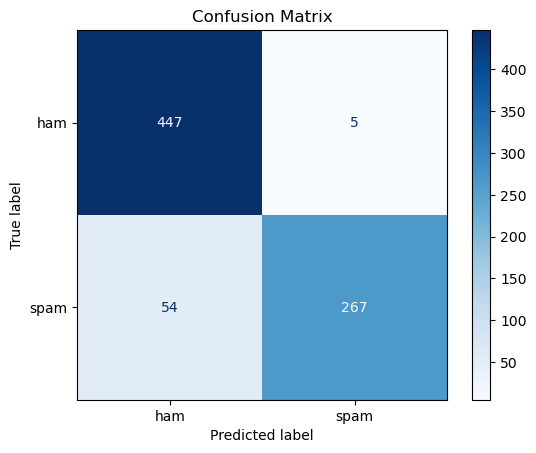

In [41]:
r = top_f1_run['r'] # Get r threshold


y_pred = classify_dataset(X_test, detectors_array, r) # Predictions on test set

f1_spam = f1_score(y_val, y_pred, pos_label='spam', zero_division=np.NaN) # F1 for spam 
precision_spam = precision_score(y_val, y_pred, pos_label='spam', zero_division=np.NaN) # Precision for spam
recall_spam = recall_score(y_val, y_pred, pos_label='spam', zero_division=np.NaN) # Recall for spam
    
cm = confusion_matrix(y_val, y_pred, labels=['ham','spam']) # Confusion matrix
tn, fp, fn, tp = cm.ravel() # True negatives, false positives, false negatives, true positives
fpr_ham = fp / (fp + tn) # False positive rate for ham

print("F1 Spam:: ", f1_spam)
print("Precision Spam: ", precision_spam)
print("Recall Spam: ", recall_spam)
print("False Positive Rate Not Spam: ", fpr_ham)


from sklearn.metrics import ConfusionMatrixDisplay

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

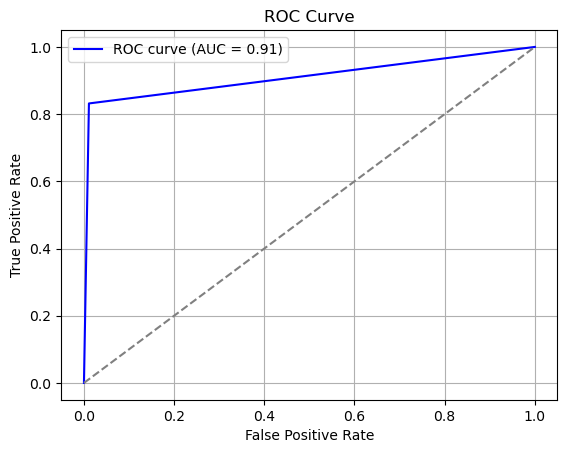

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score

# Convert labels to binary for roc curve and roc auc score
y_true_binary = np.array([1 if y=='spam' else 0 for y in y_val])
y_pred_binary = np.array([1 if y=='spam' else 0 for y in y_pred])

fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_binary) # Compute ROC curve

roc_auc = roc_auc_score(y_true_binary, y_pred_binary) # Compute ROC-AUC


# Plot ROC curve
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--')  # Ddiagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

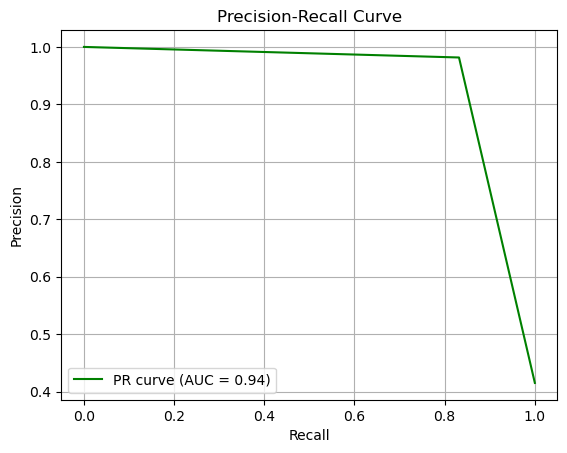

In [43]:
from sklearn.metrics import precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_true_binary, y_pred_binary) # Compute precision recall curve
pr_auc = auc(recall, precision) # Compute area under curve


# Plot precision recall curve
plt.plot(recall, precision, color='green', label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

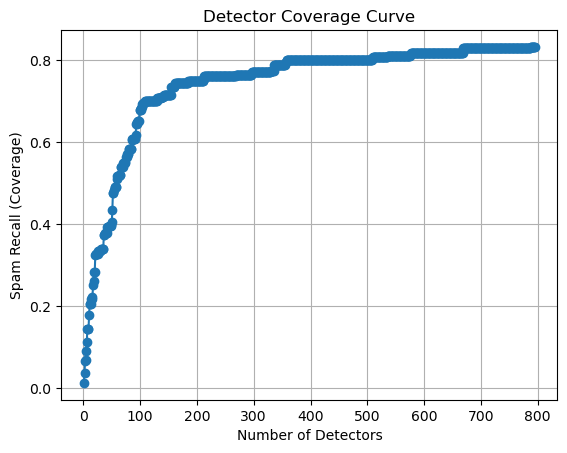

In [44]:
def detector_coverage_curve(X_spam, detectors, r):
    """
    Plots recall coverage vs number of detectors used.

    :param X_spam: Encoded spam messages.
    :param detectors: Array of detectors.
    :r 

    X_spam: encoded spam messages (non-self)
    detectors: numpy array of detectors
    :param r: Hamming distance threshold. Distance must be lower or equal to r to be classified as spam.
    """

    n_detectors = len(detectors)
    coverage = []

    matched = np.zeros(len(X_spam), dtype=bool) # Initialize array to track which spam messages have been matched

    # Loop through detectors
    for i in range(n_detectors):
        detector = detectors[i] 
        
        dists = np.mean(X_spam != detector, axis=1) # Compute Hamming distance between current detector and all spam messages
        
        matched |= (dists <= r) # Mark spam messages matched by this detector

        coverage.append(np.sum(matched) / len(X_spam)) # Recall coverage. Recall = True Spam/ (True Spam + False Ham)

    # Plot detector coverage curve
    plt.plot(range(1, n_detectors+1), coverage, marker='o')
    plt.xlabel('Number of Detectors')
    plt.ylabel('Spam Recall (Coverage)')
    plt.title('Detector Coverage Curve')
    plt.grid(True)
    plt.show()

detector_coverage_curve(encode_spam_test, detectors=top_f1_run["detectors"], r=top_f1_run['r'])
